### This jupyter notebooks provides the code for classifying signals using DCT and various DWTs, with various lengths of truncation.

In [1]:
import os
from time import perf_counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pywt
from collections import defaultdict, Counter

import keras
from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Activation, MaxPooling1D
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from sklearn.metrics import confusion_matrix

import pdb
history = History()

# 1. Loading the UCI HAR dataset
Download the dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
activities_description = {
    0: 'walking',
    1: 'walking upstairs',
    2: 'walking downstairs',
    3: 'sitting',
    4: 'standing',
    5: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

DATA_FOLDER = '../datasets/UCI HAR Dataset/'
INPUT_FOLDER_TRAIN = DATA_FOLDER+'train/Inertial Signals/'
INPUT_FOLDER_TEST = DATA_FOLDER+'test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = DATA_FOLDER+'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER+'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


### Let's assess the signals' frequency/scale domain properties

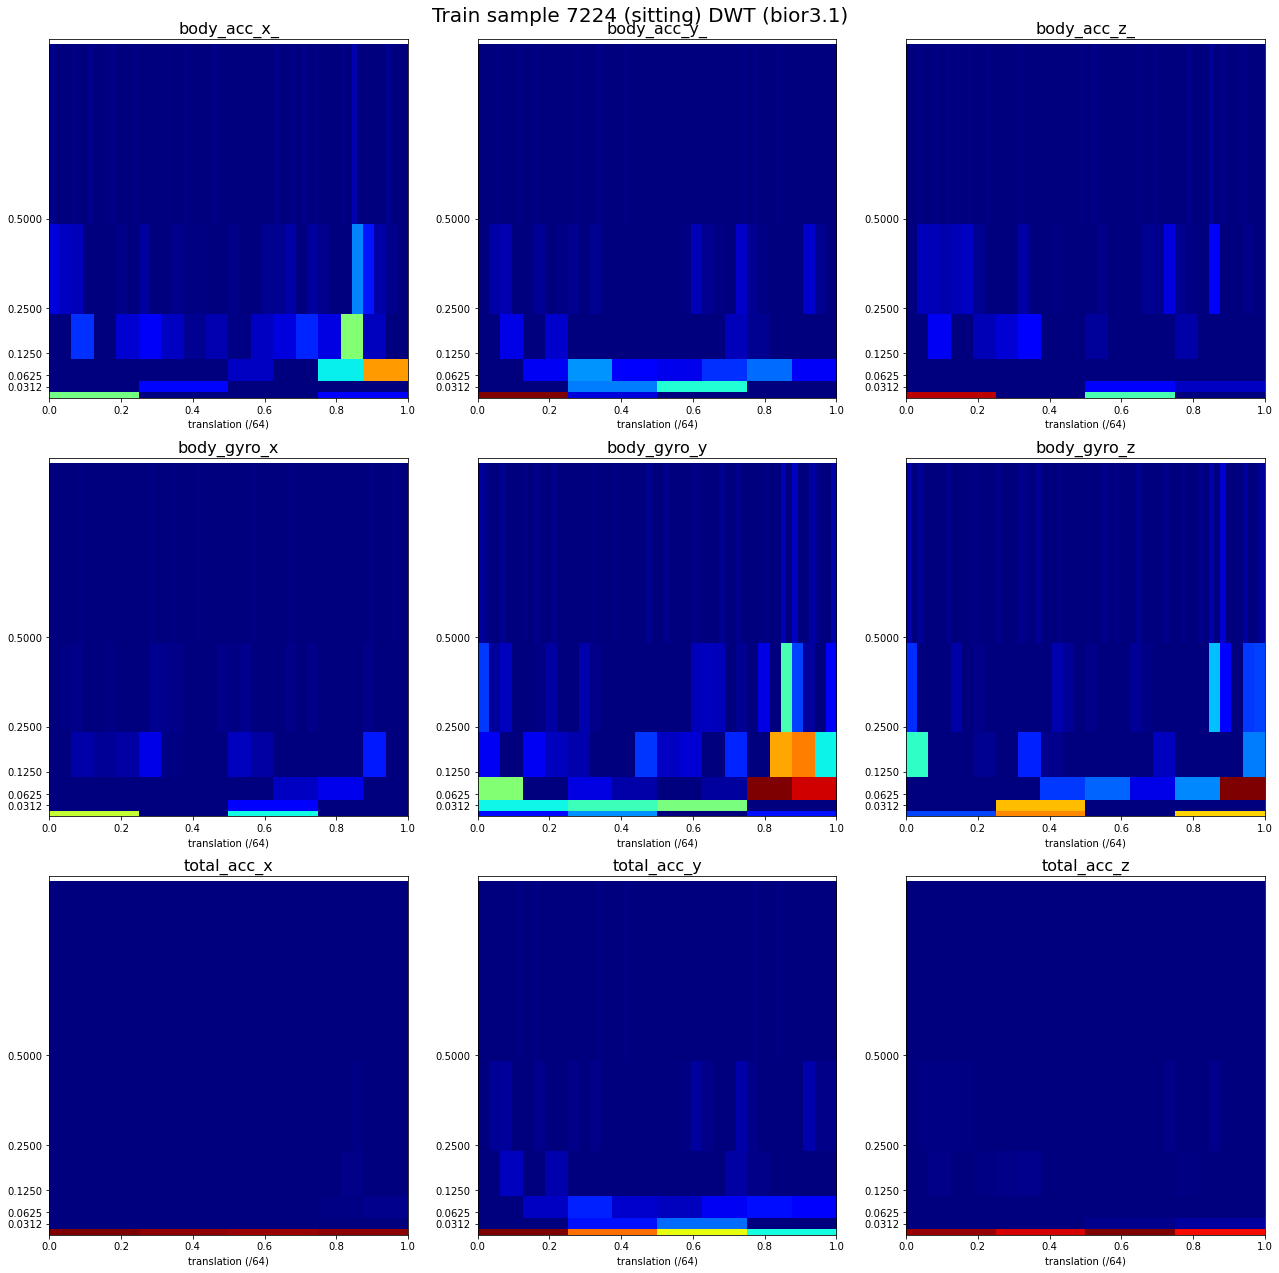

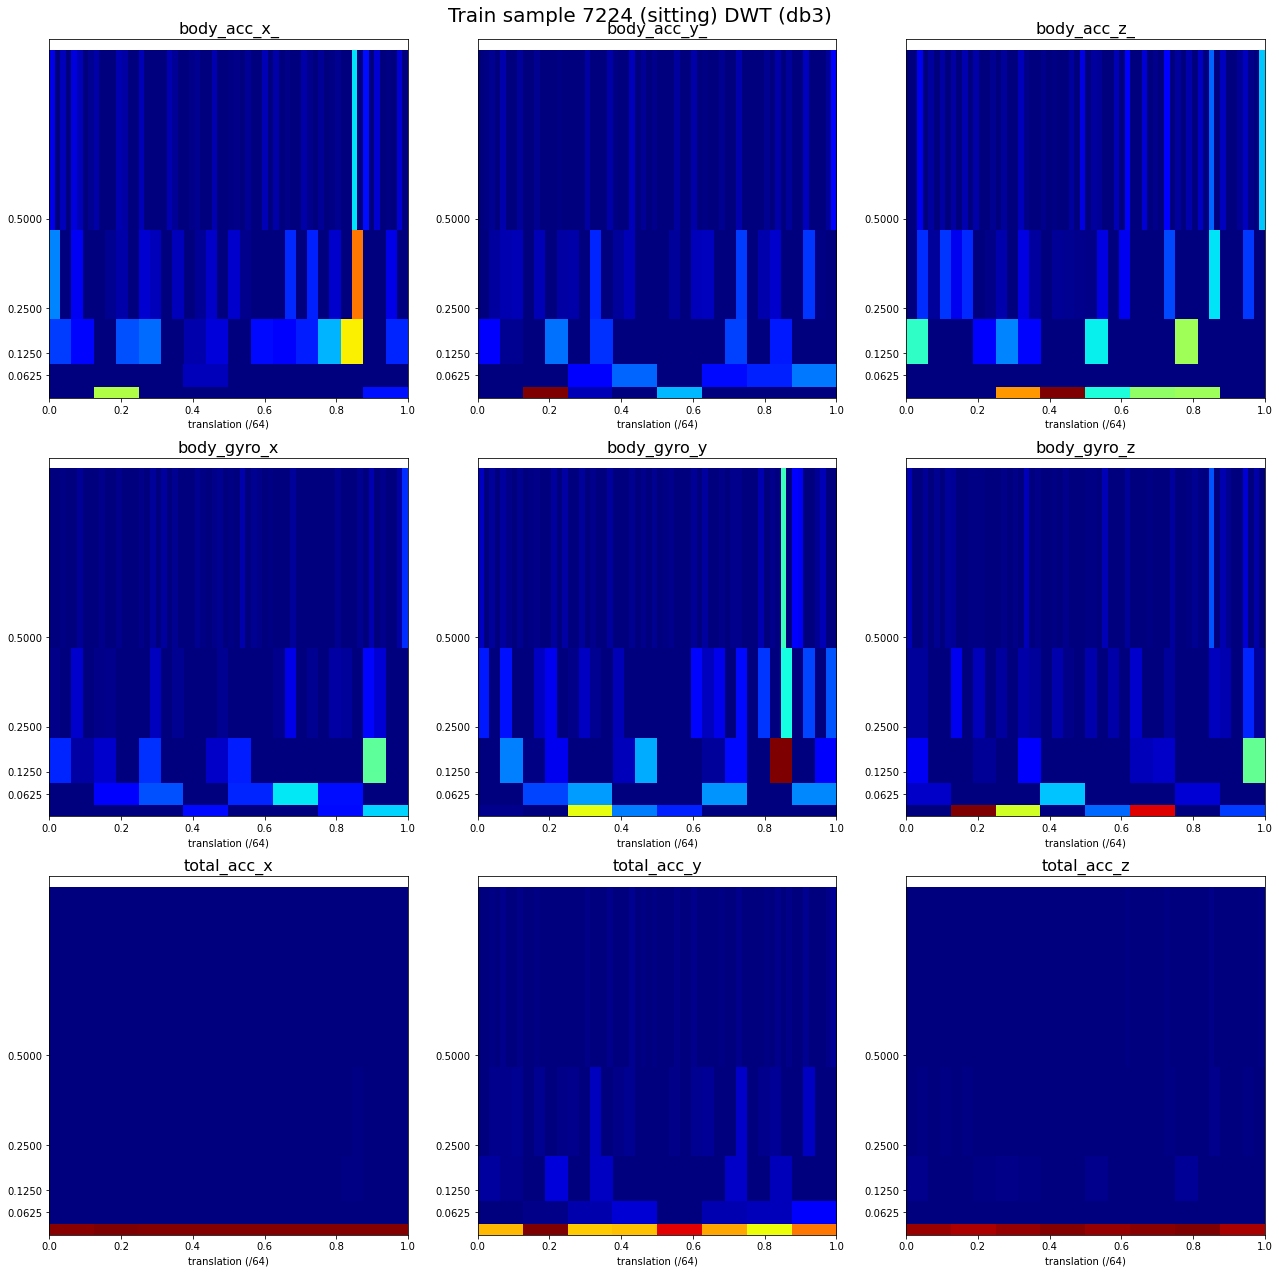

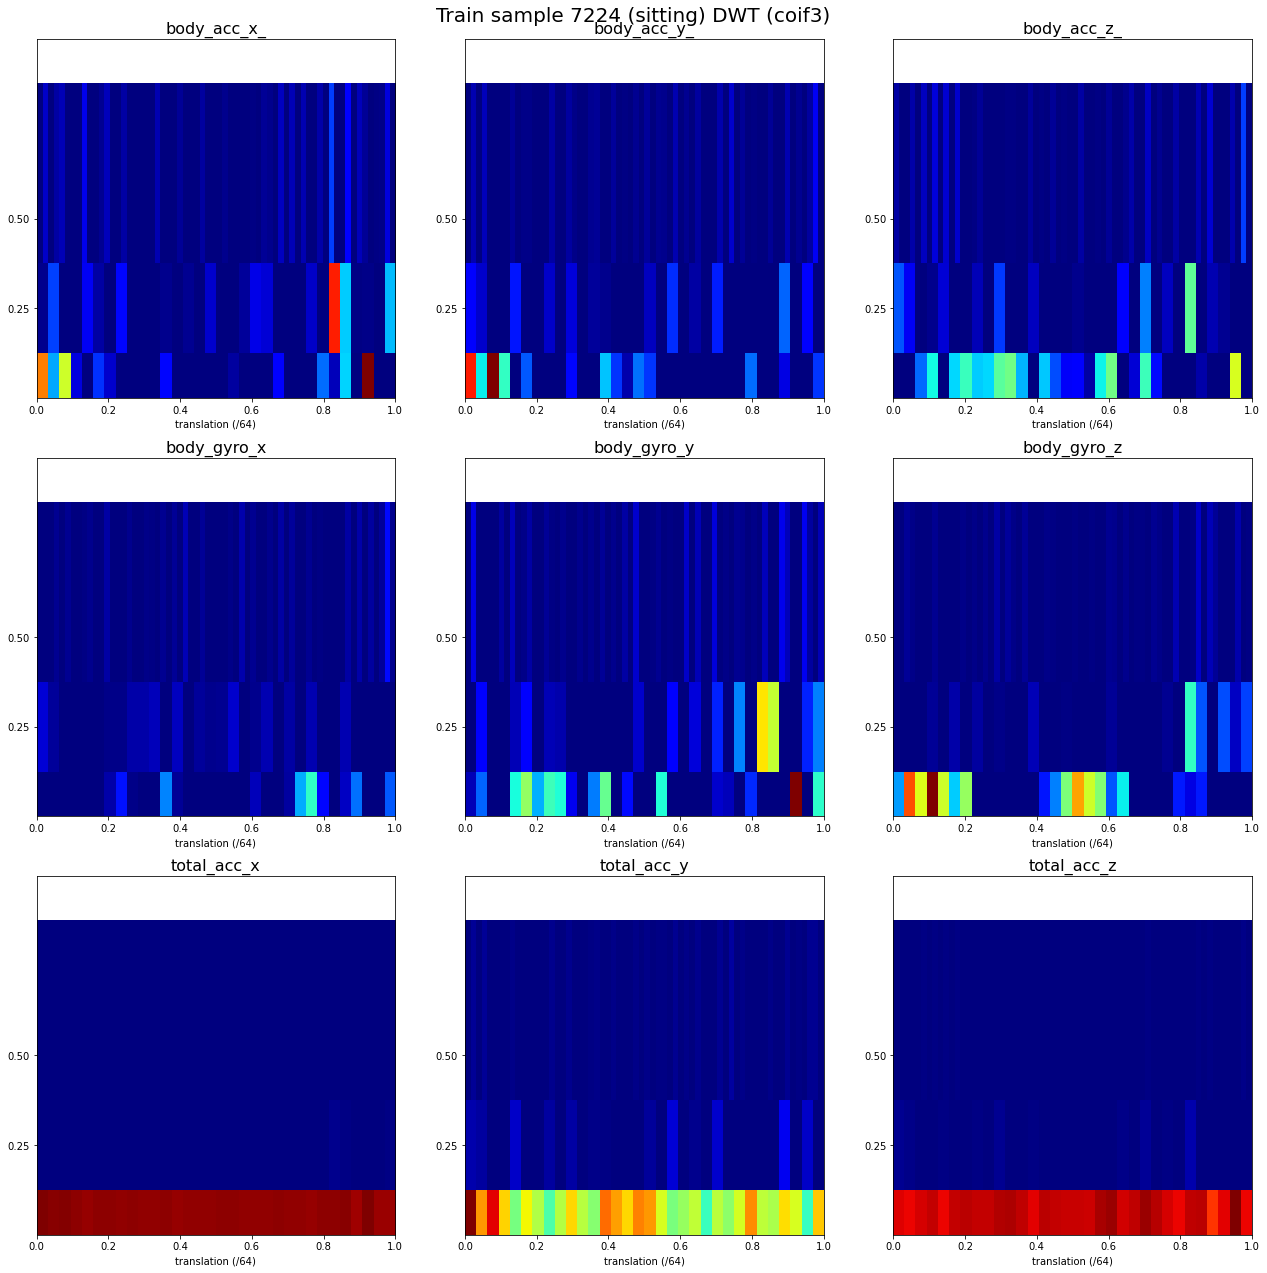

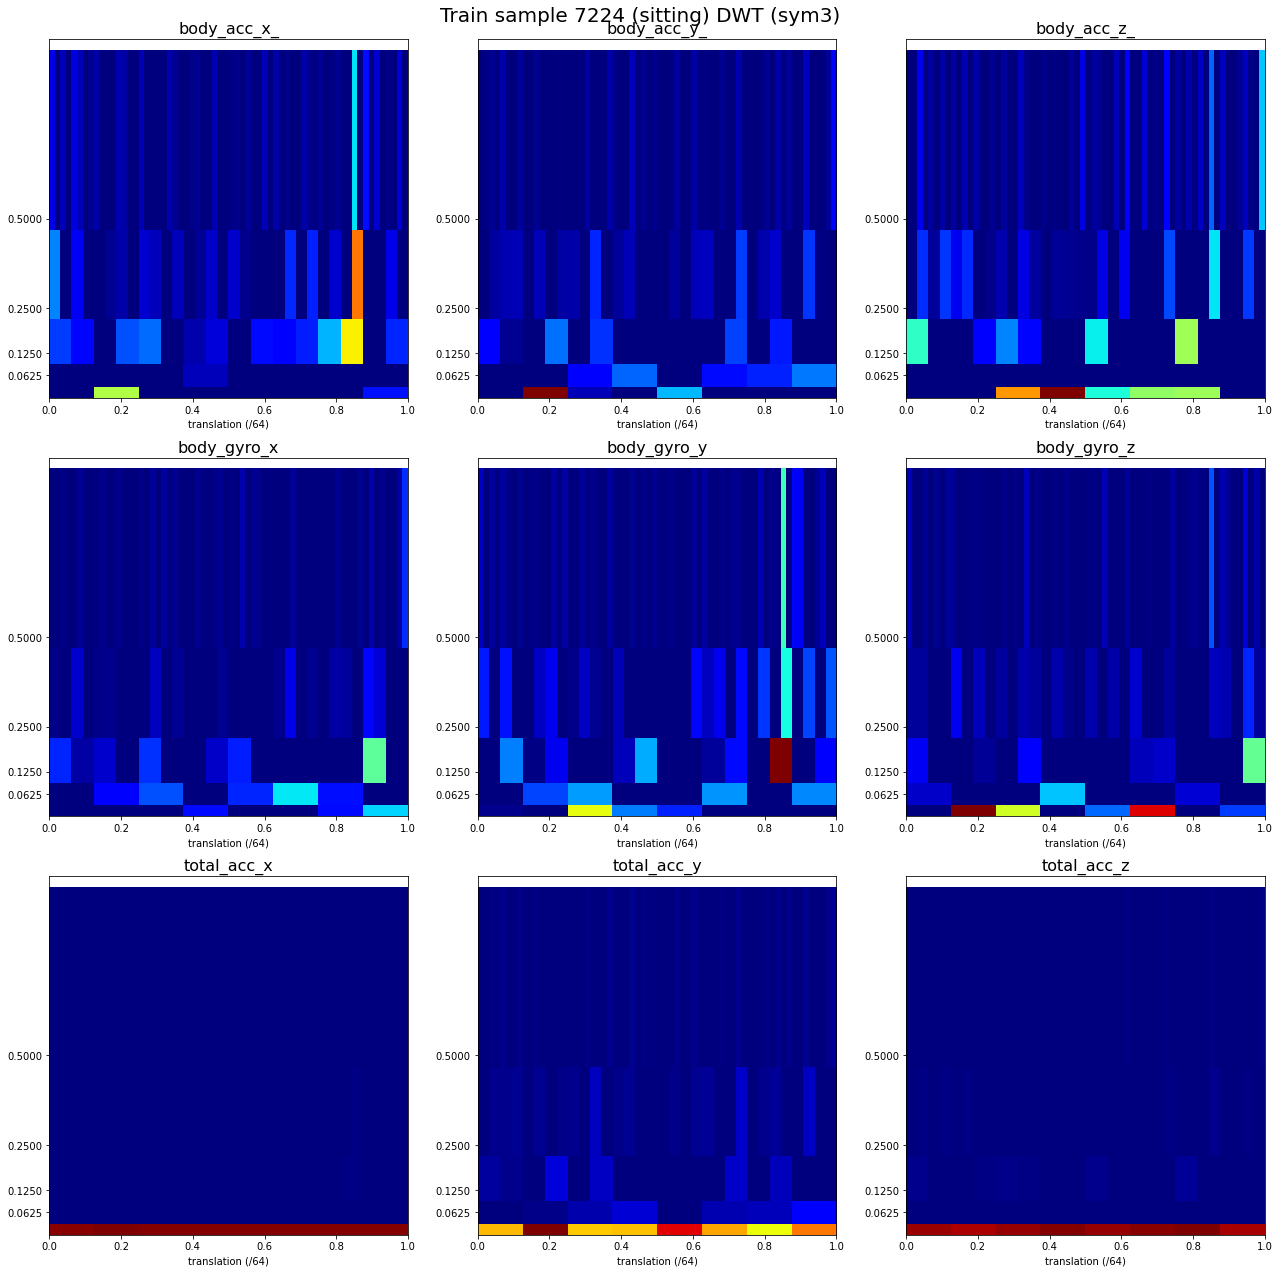

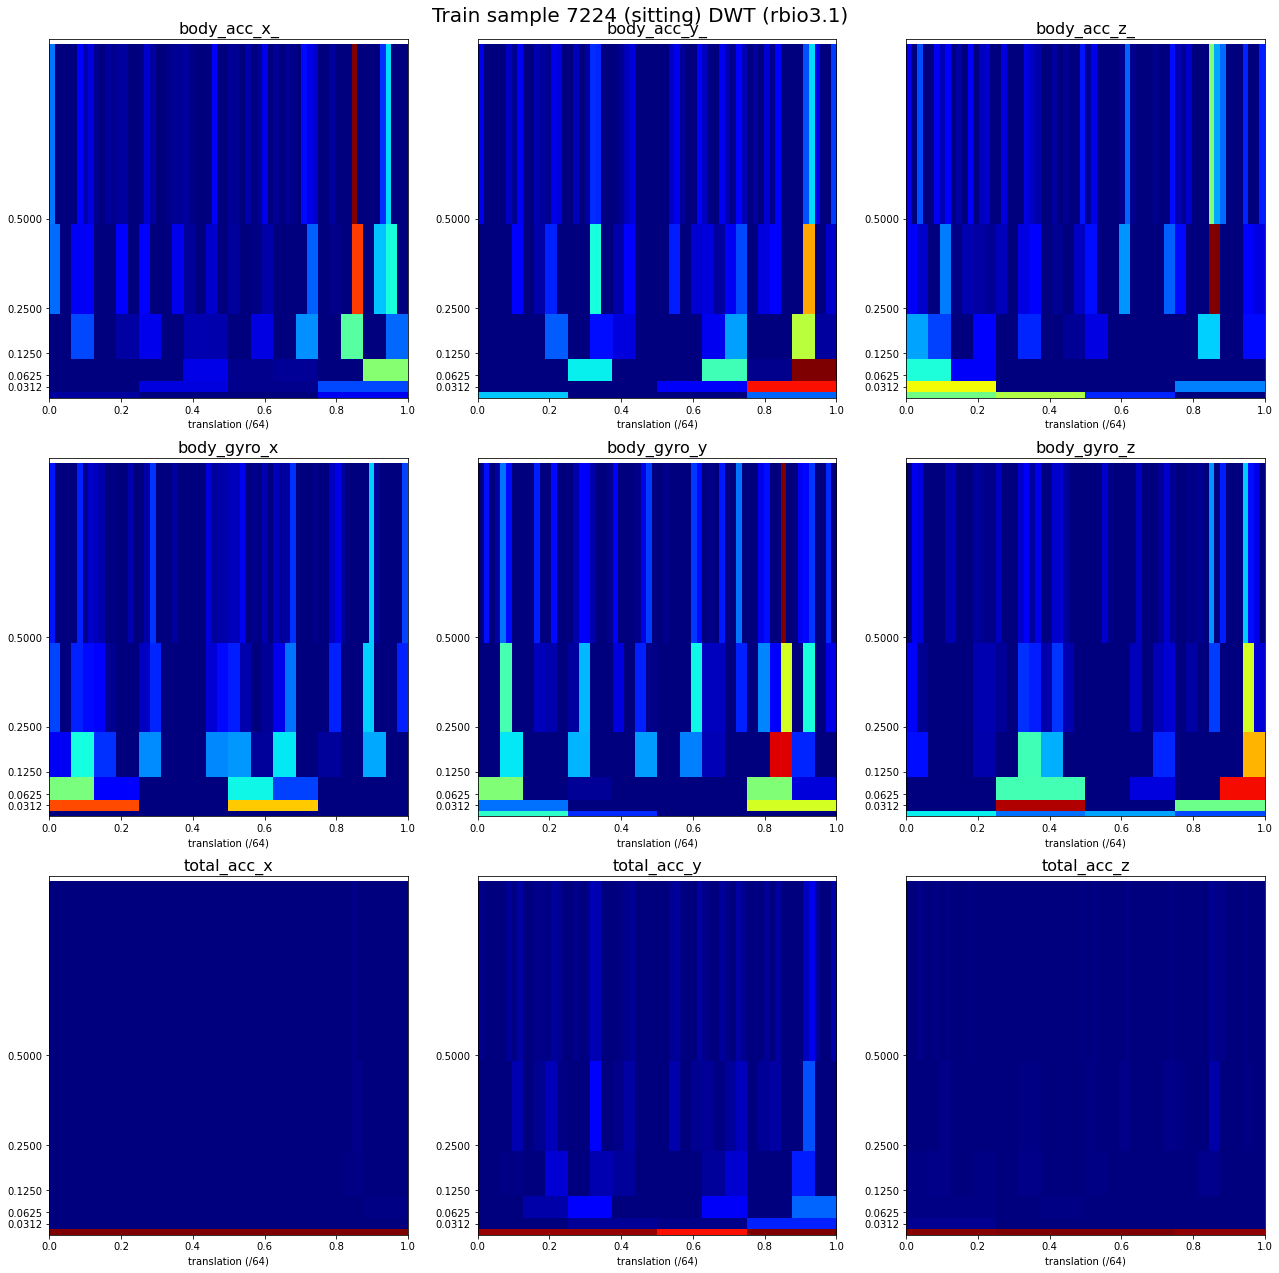

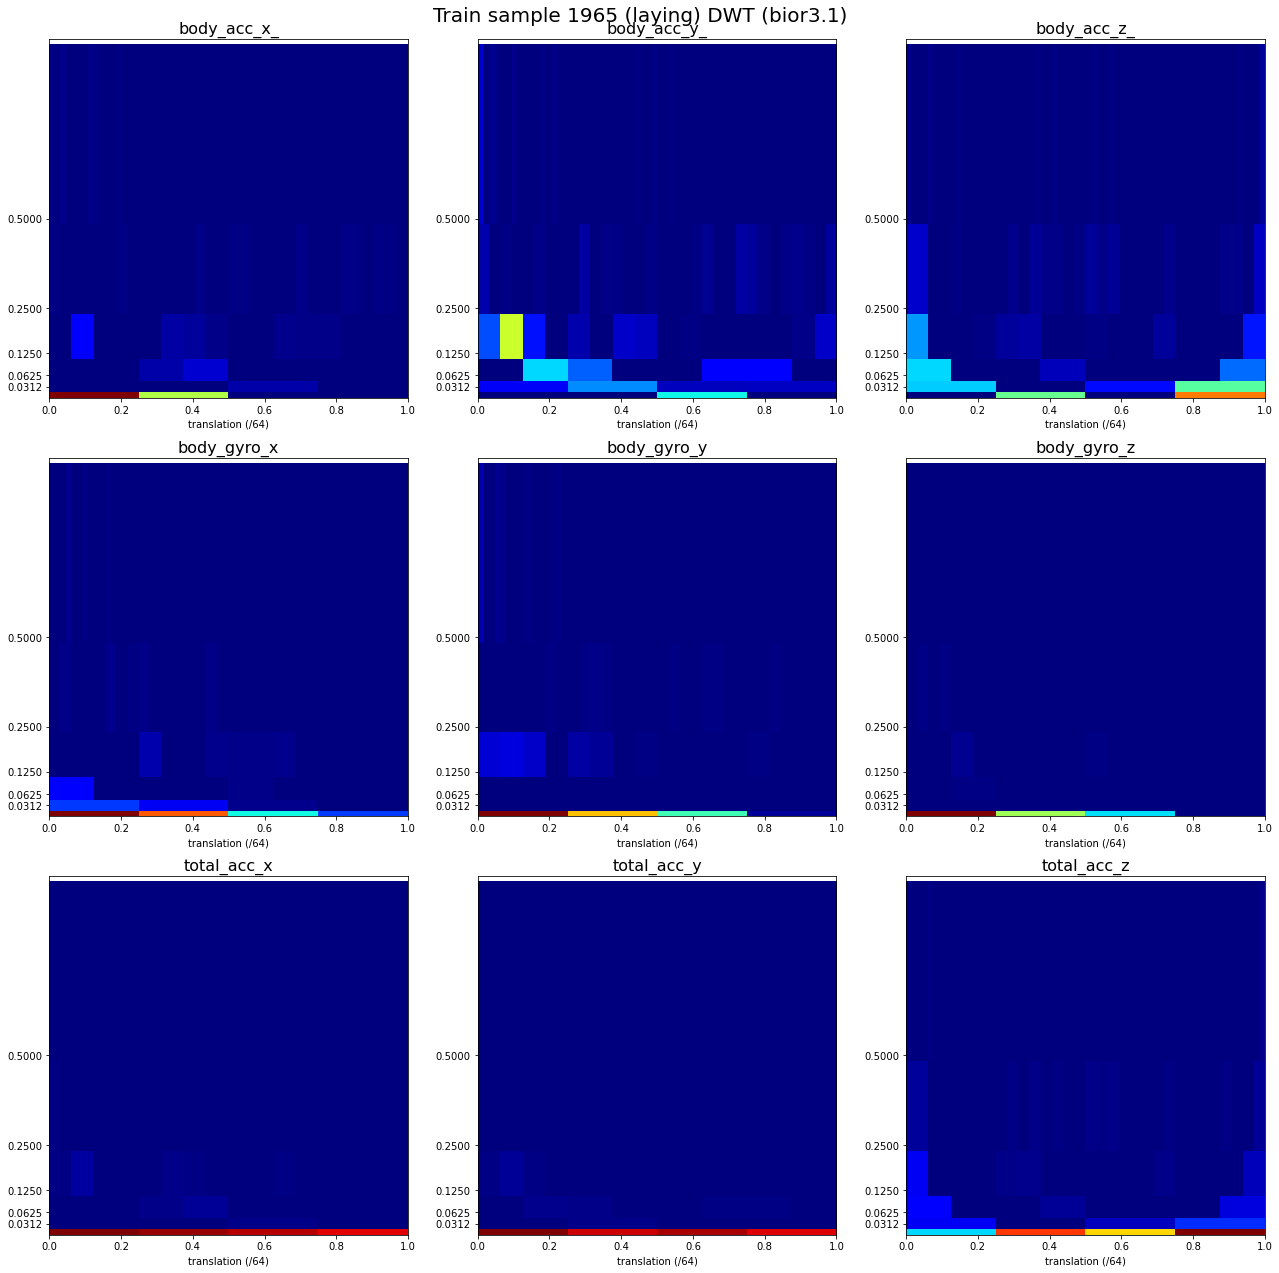

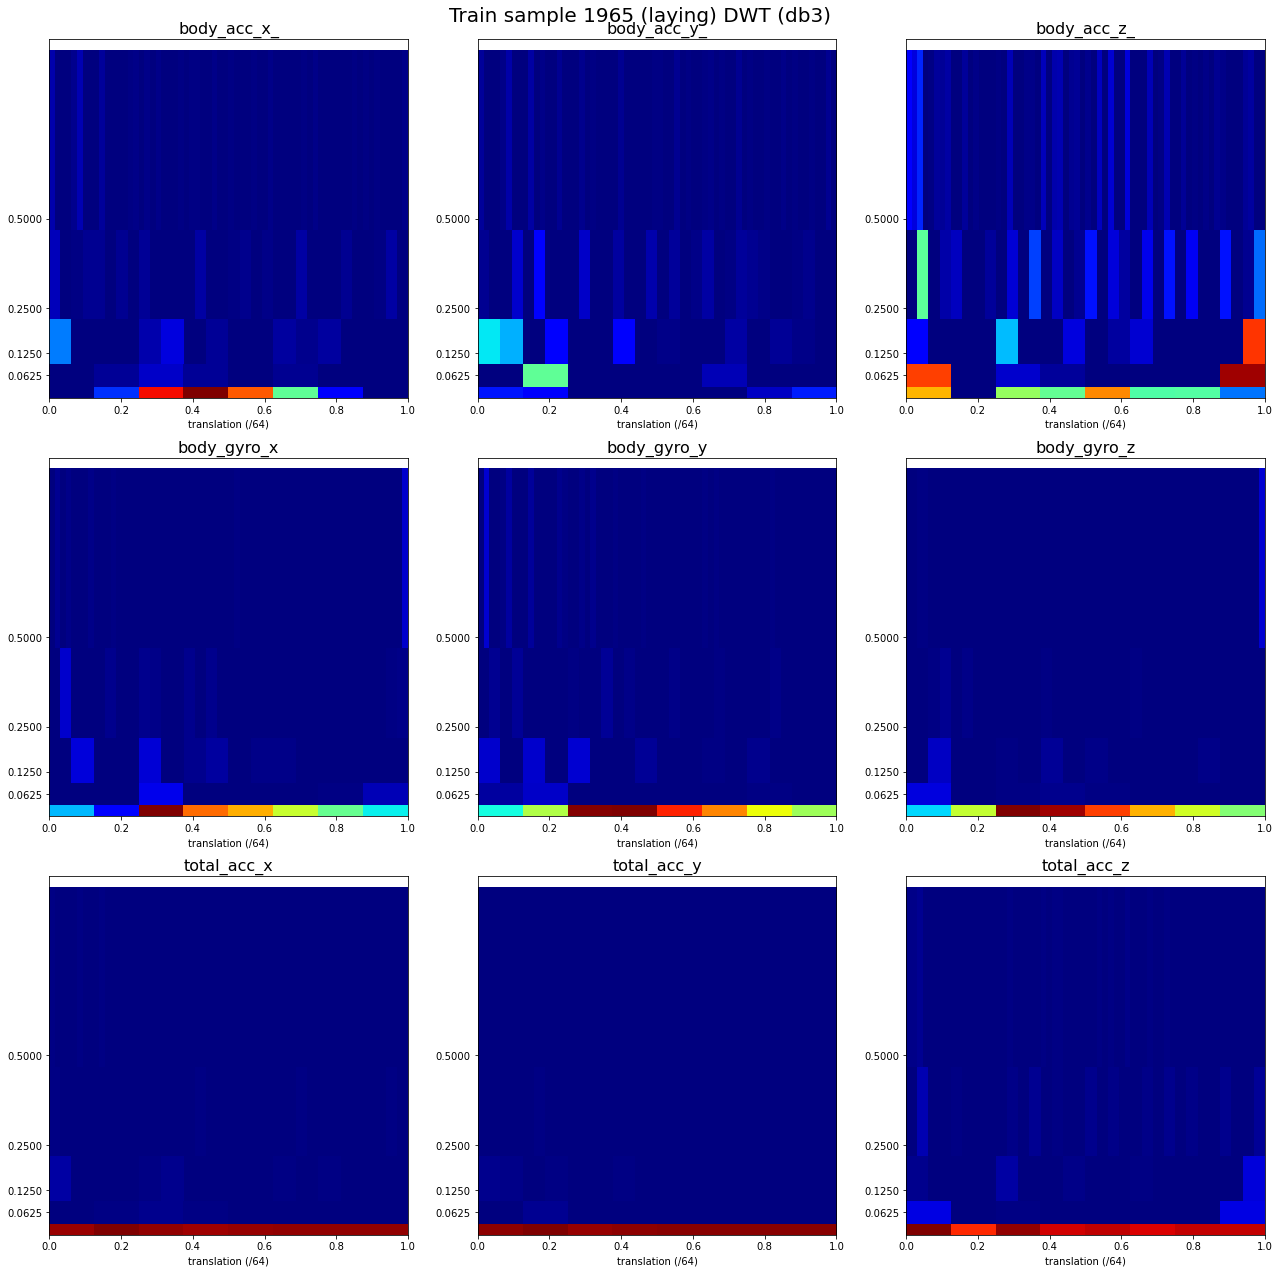

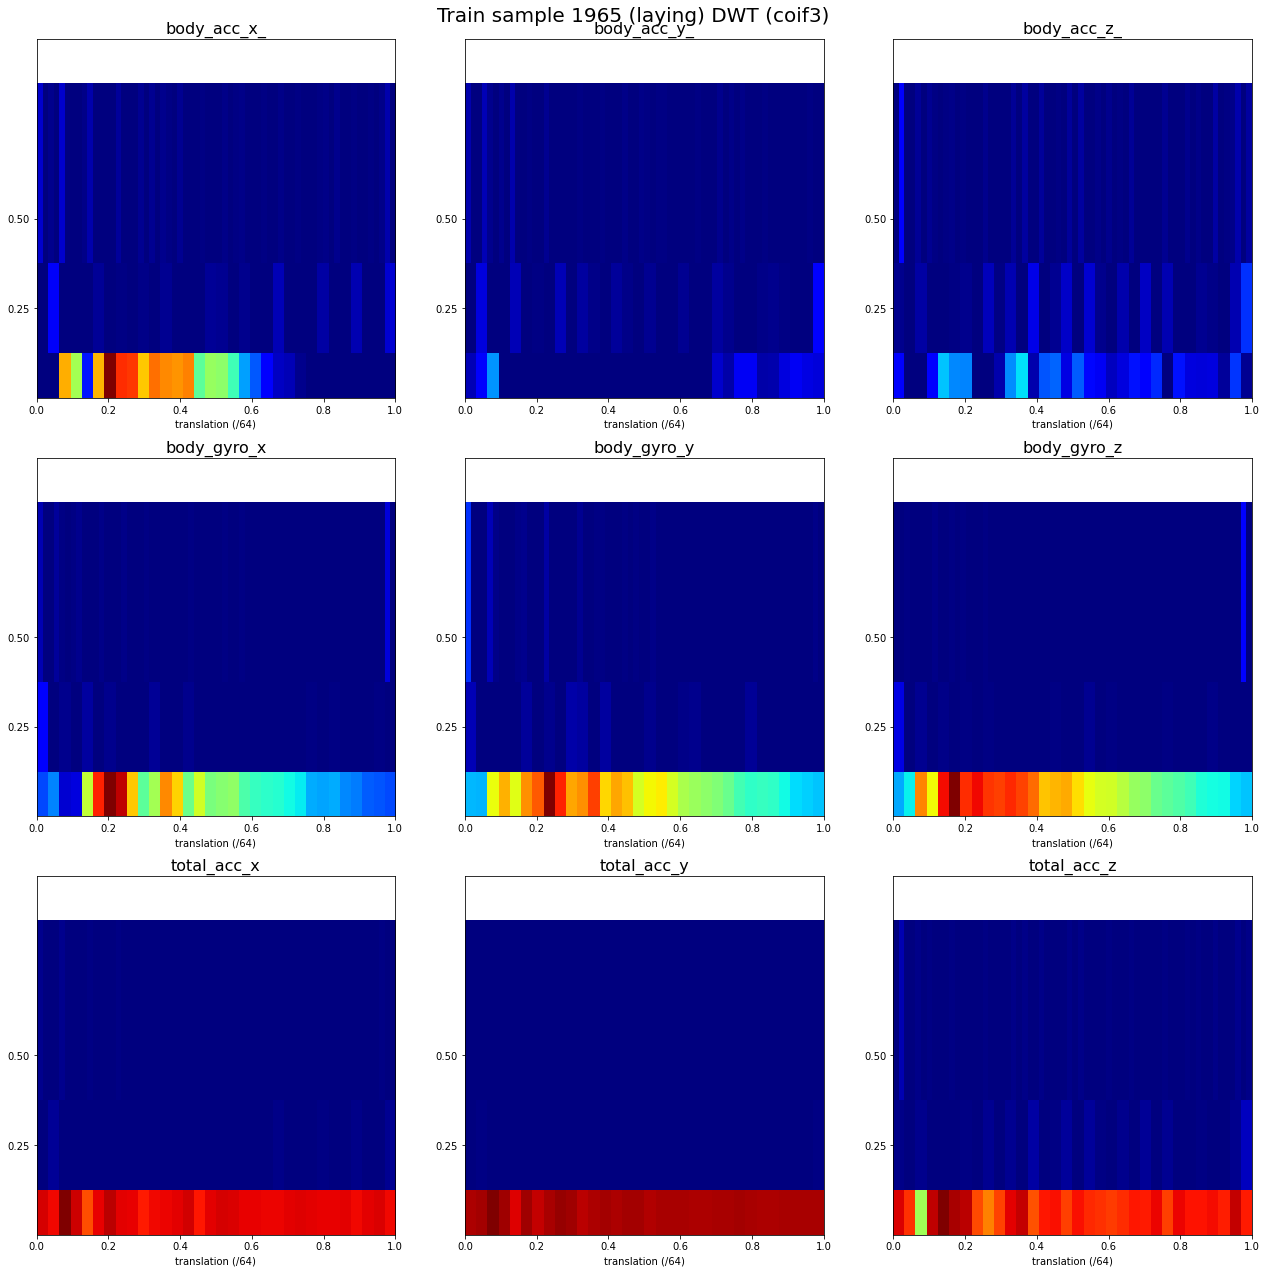

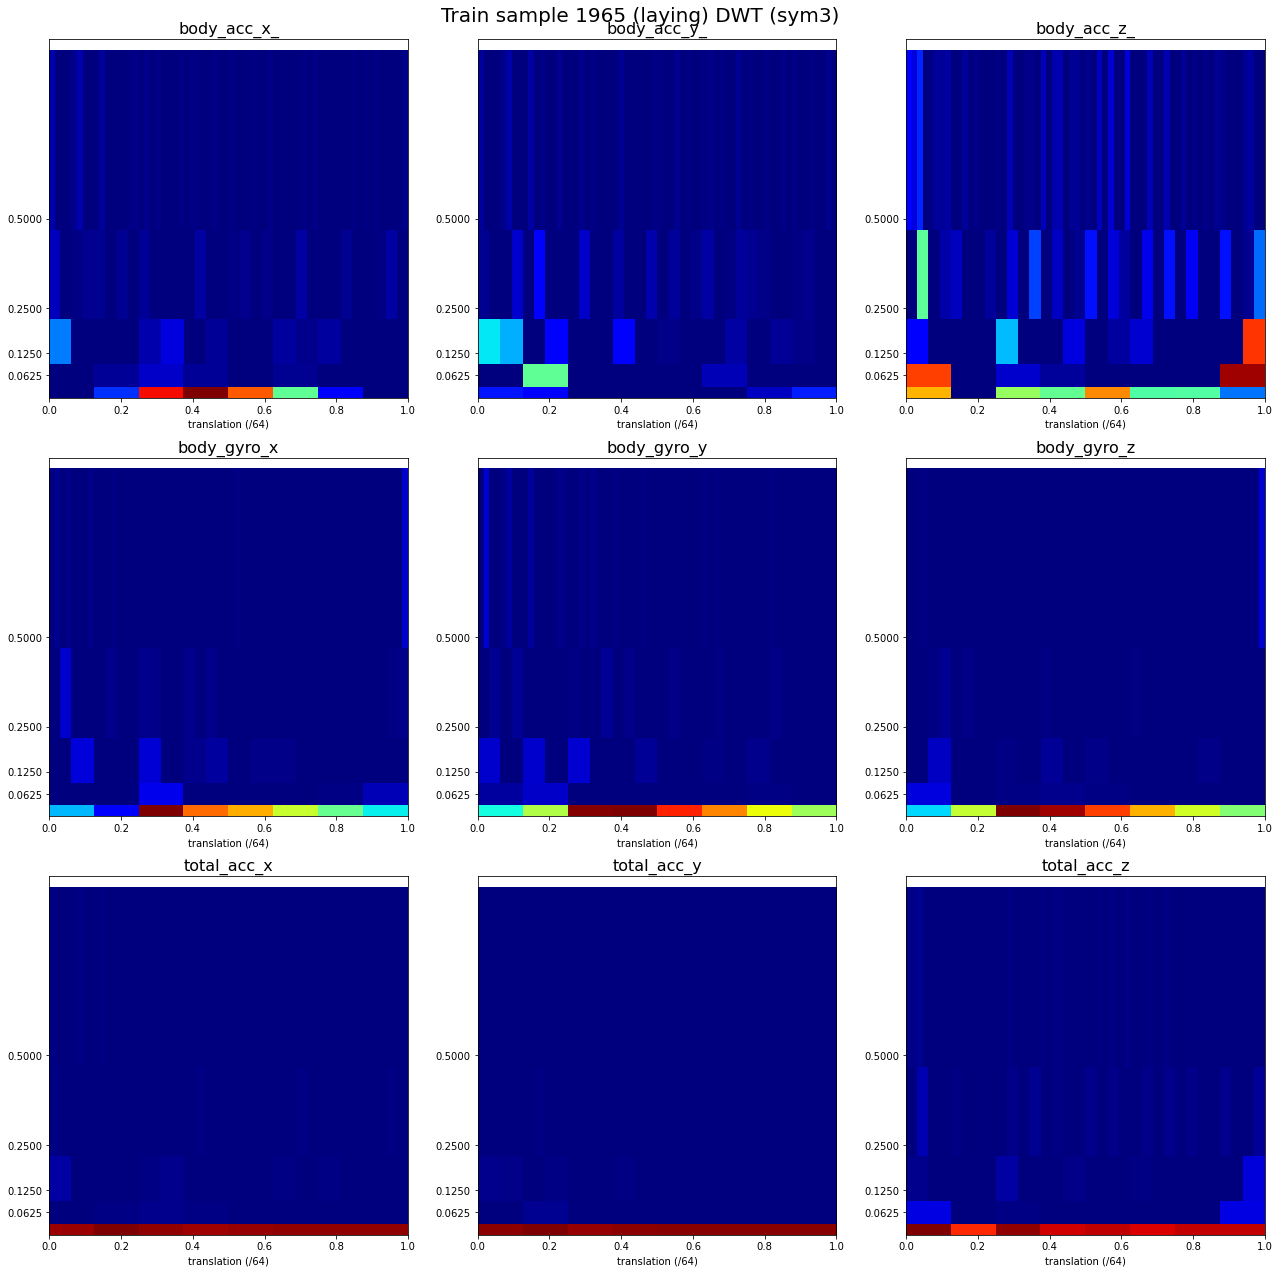

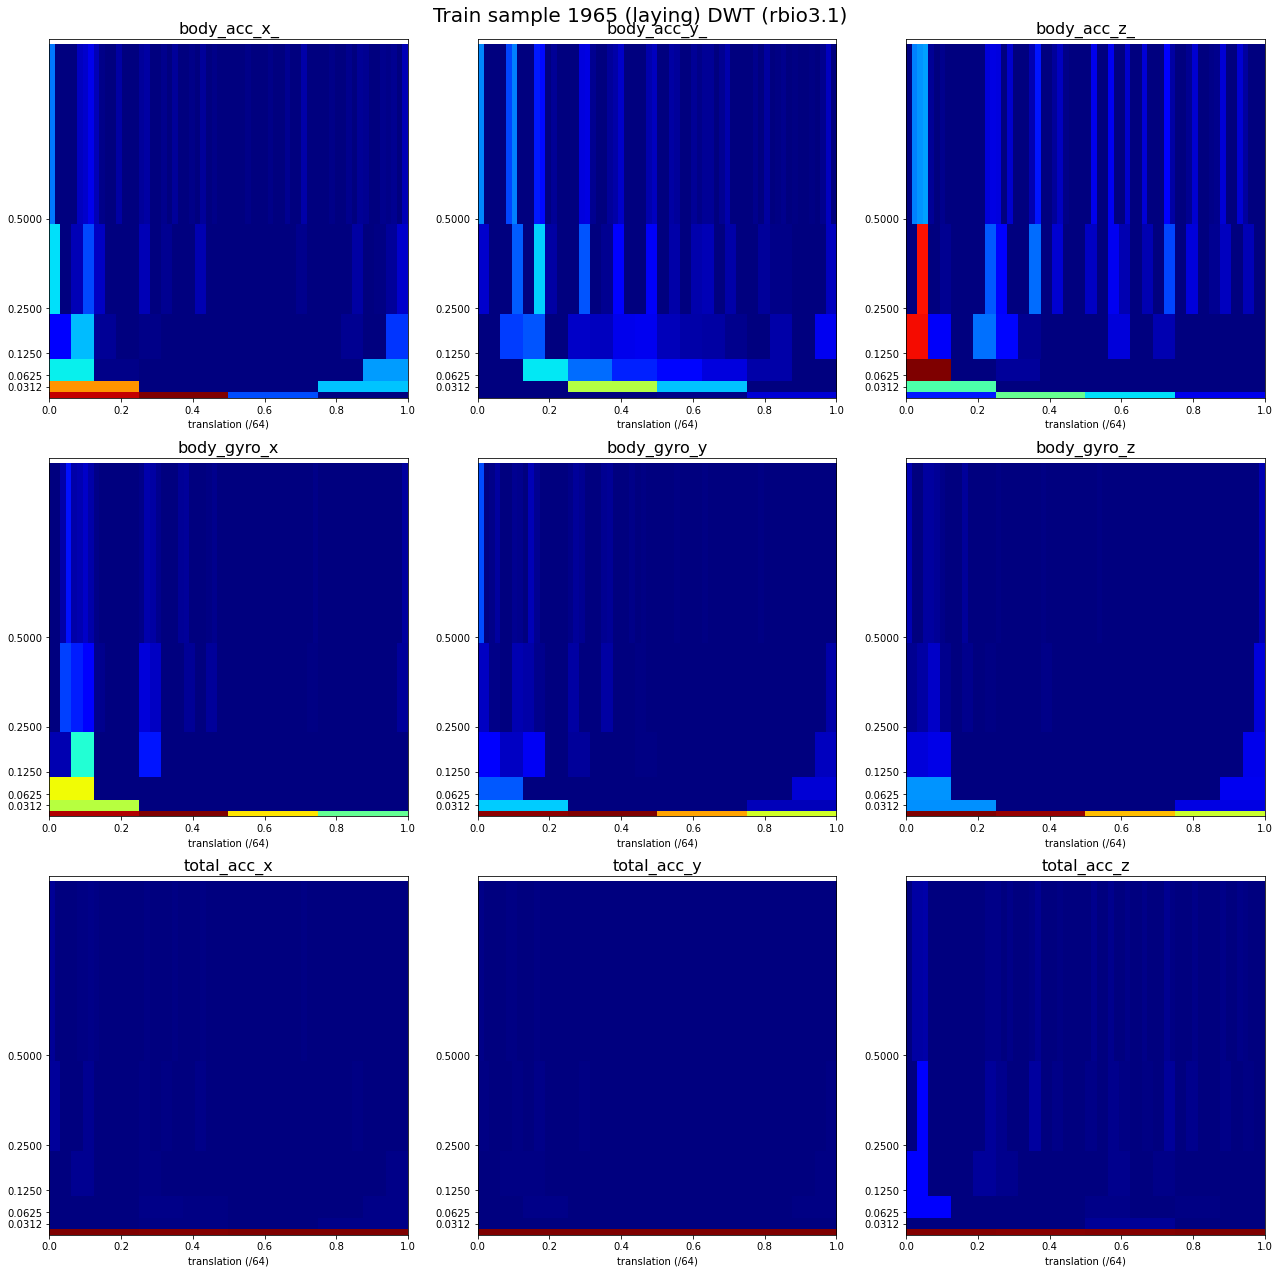

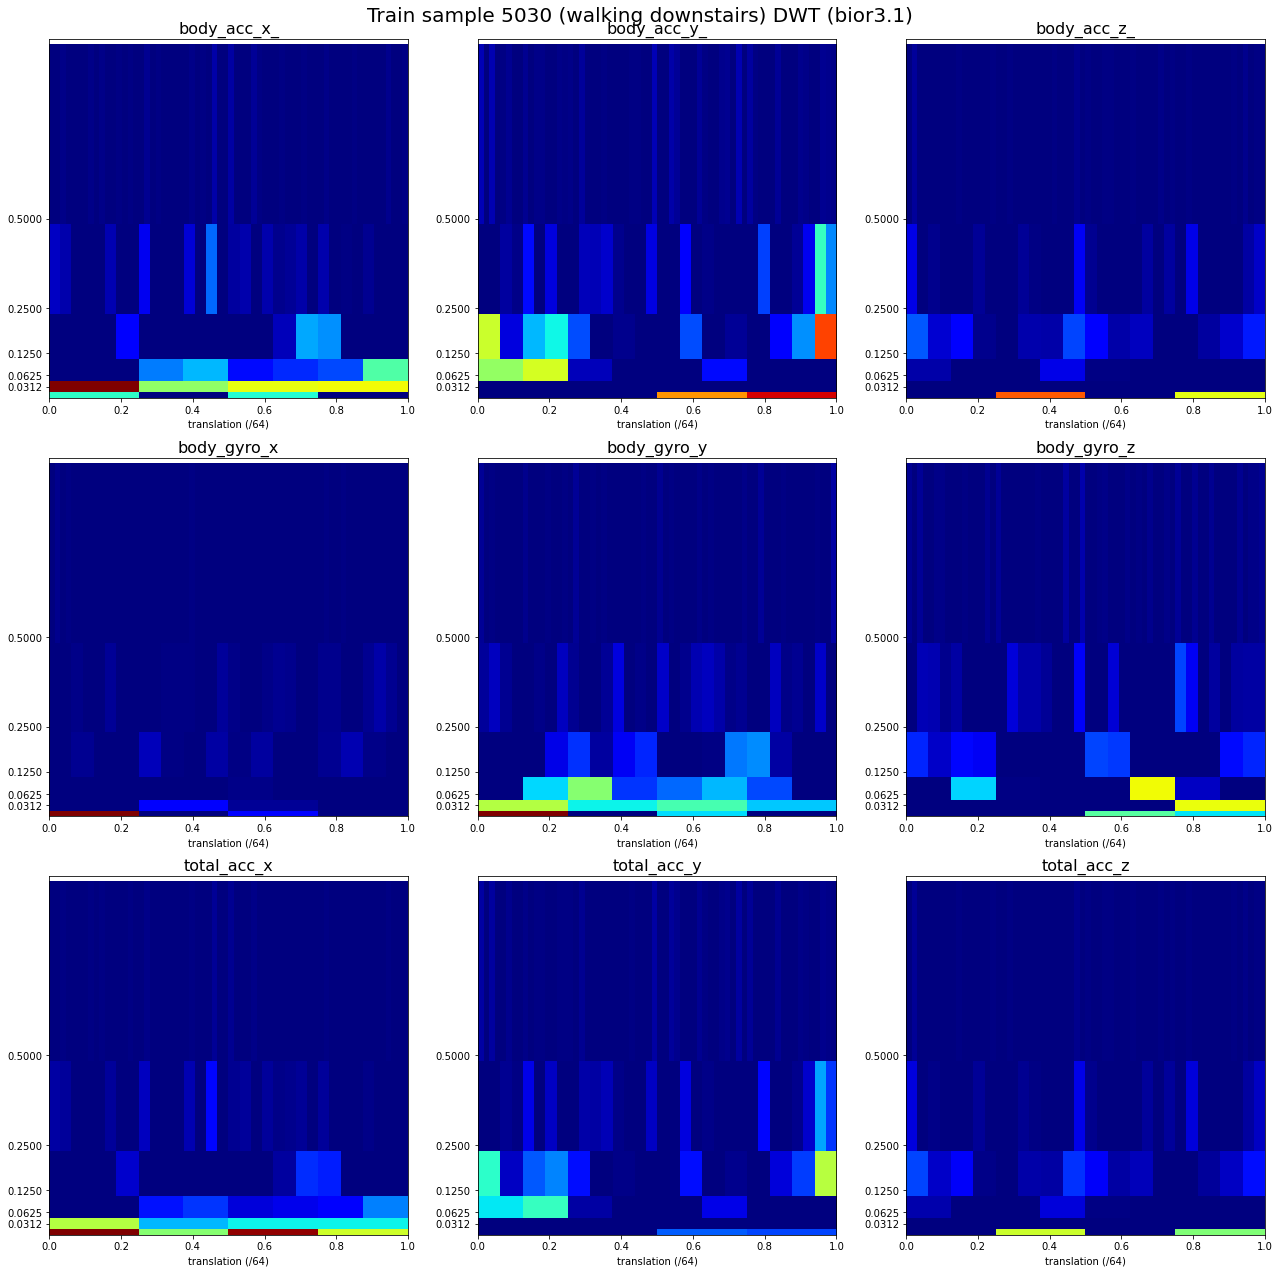

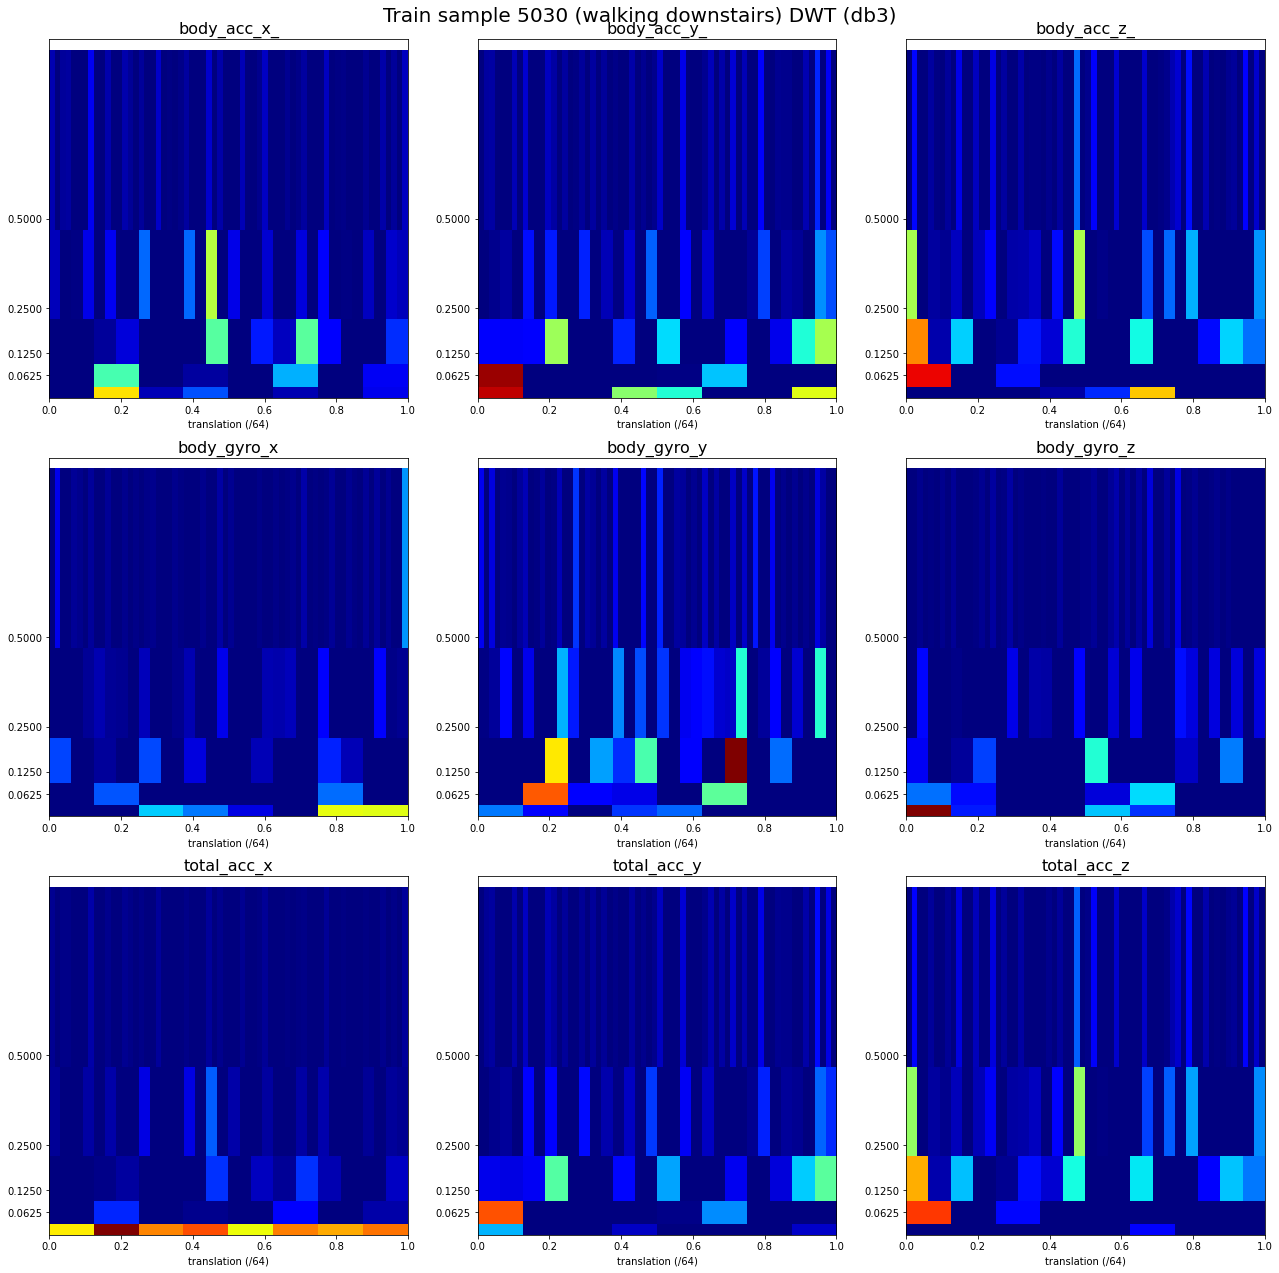

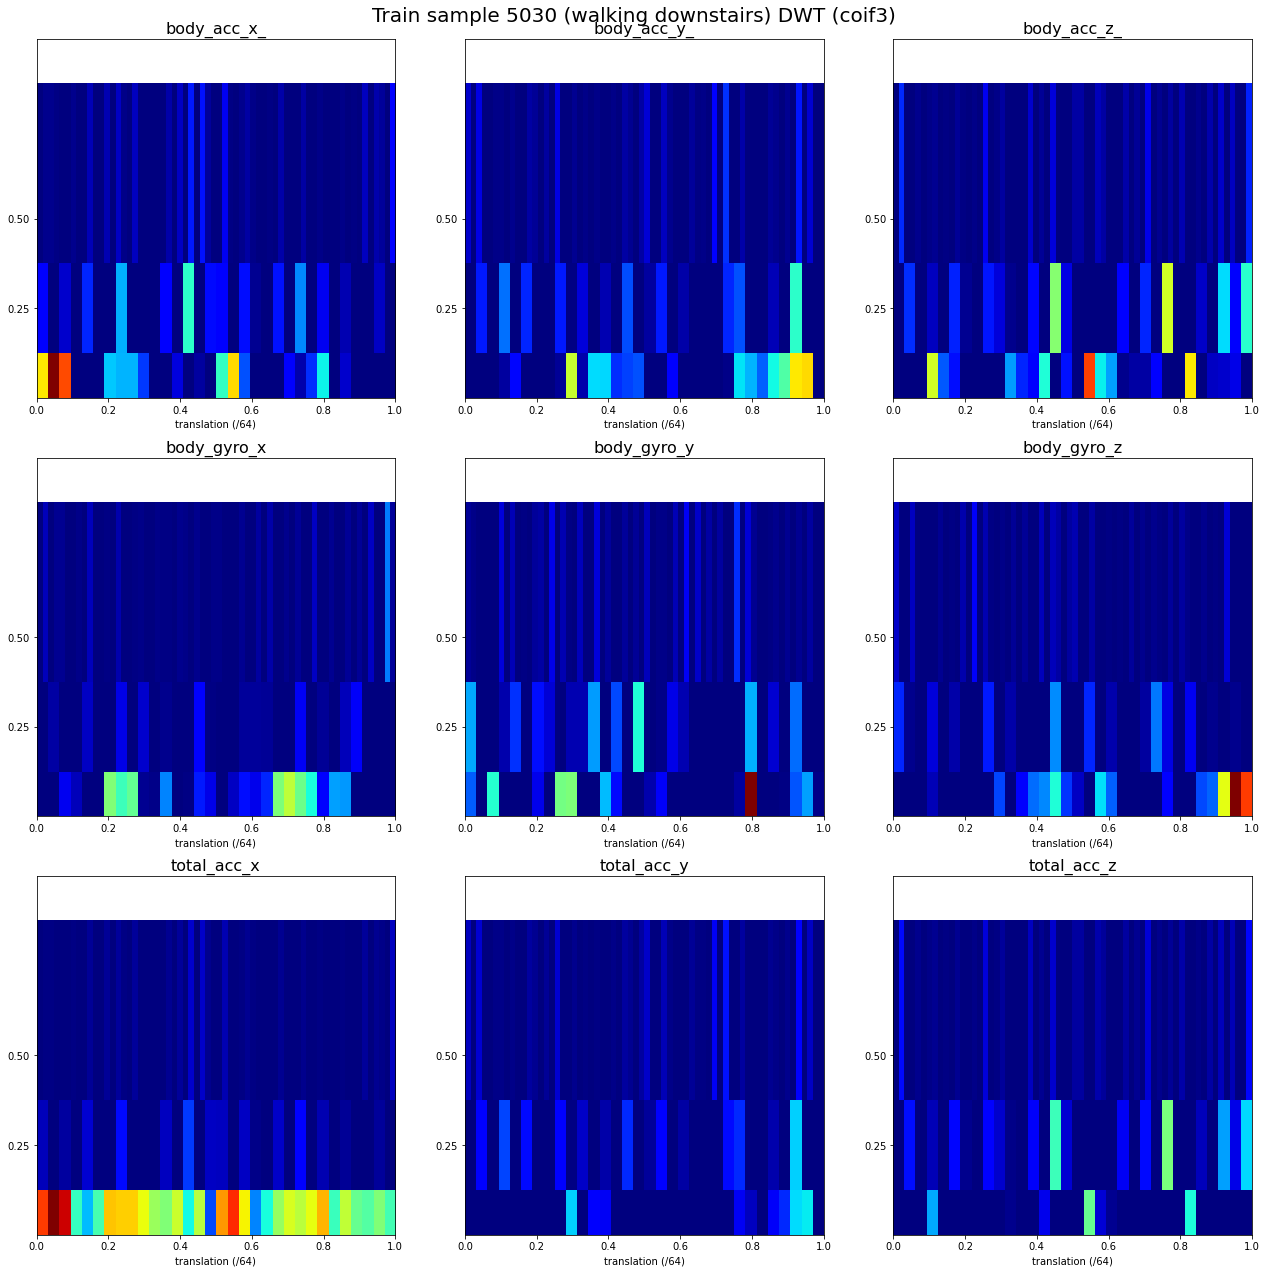

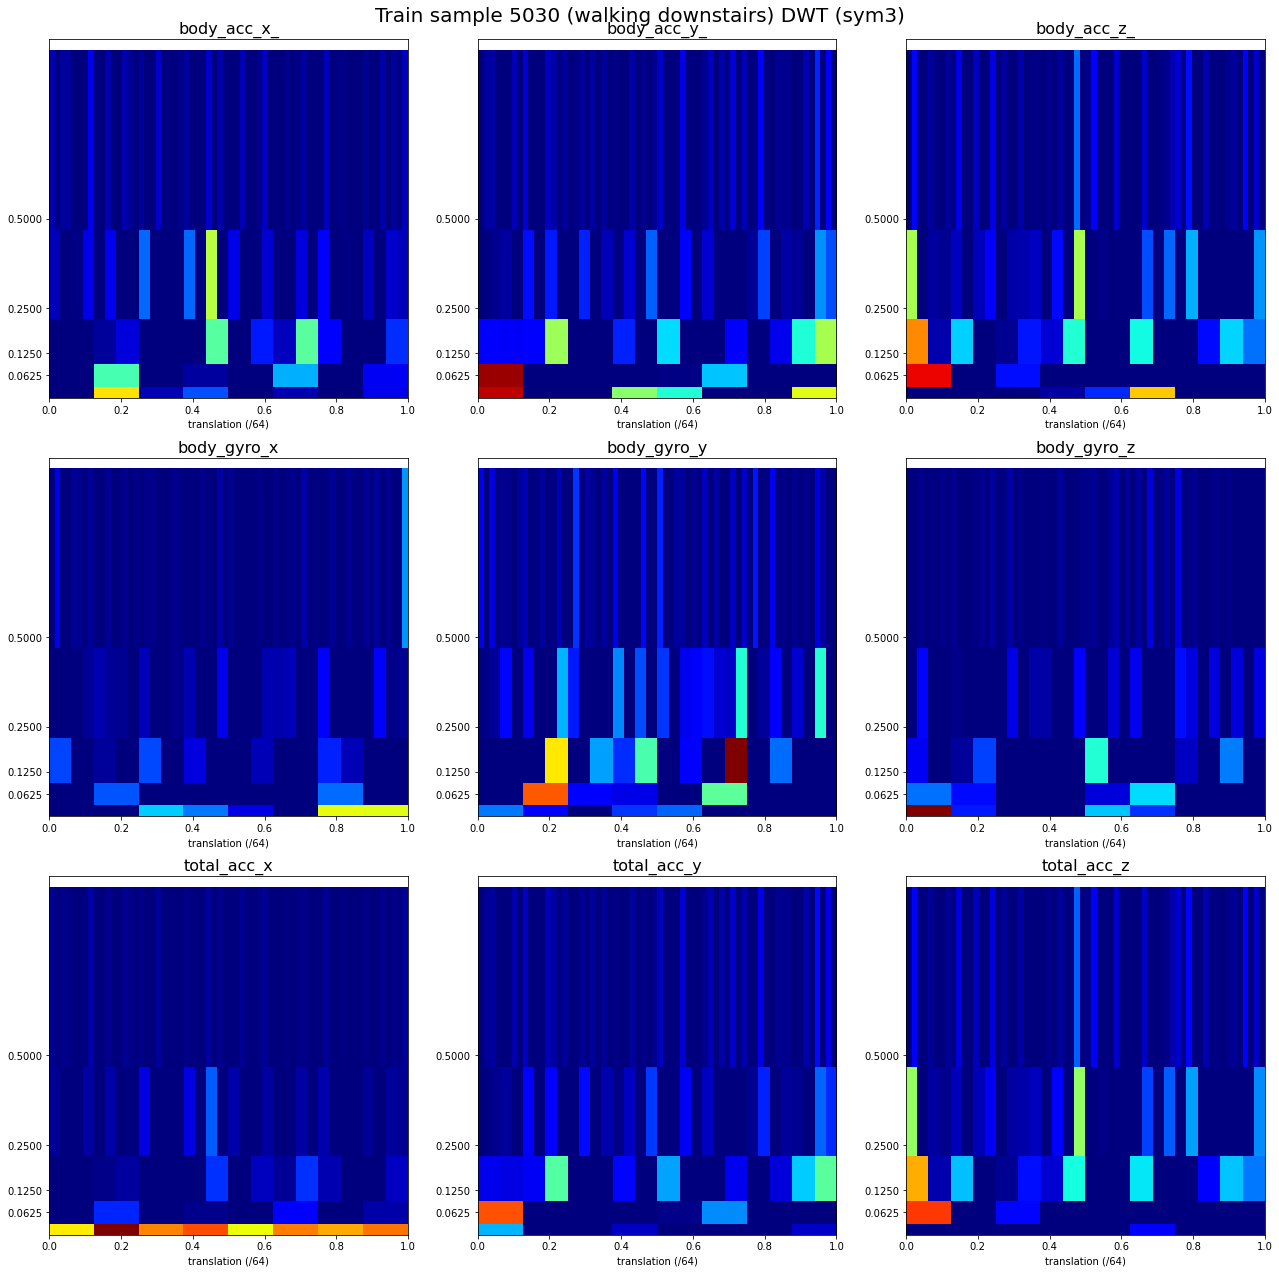

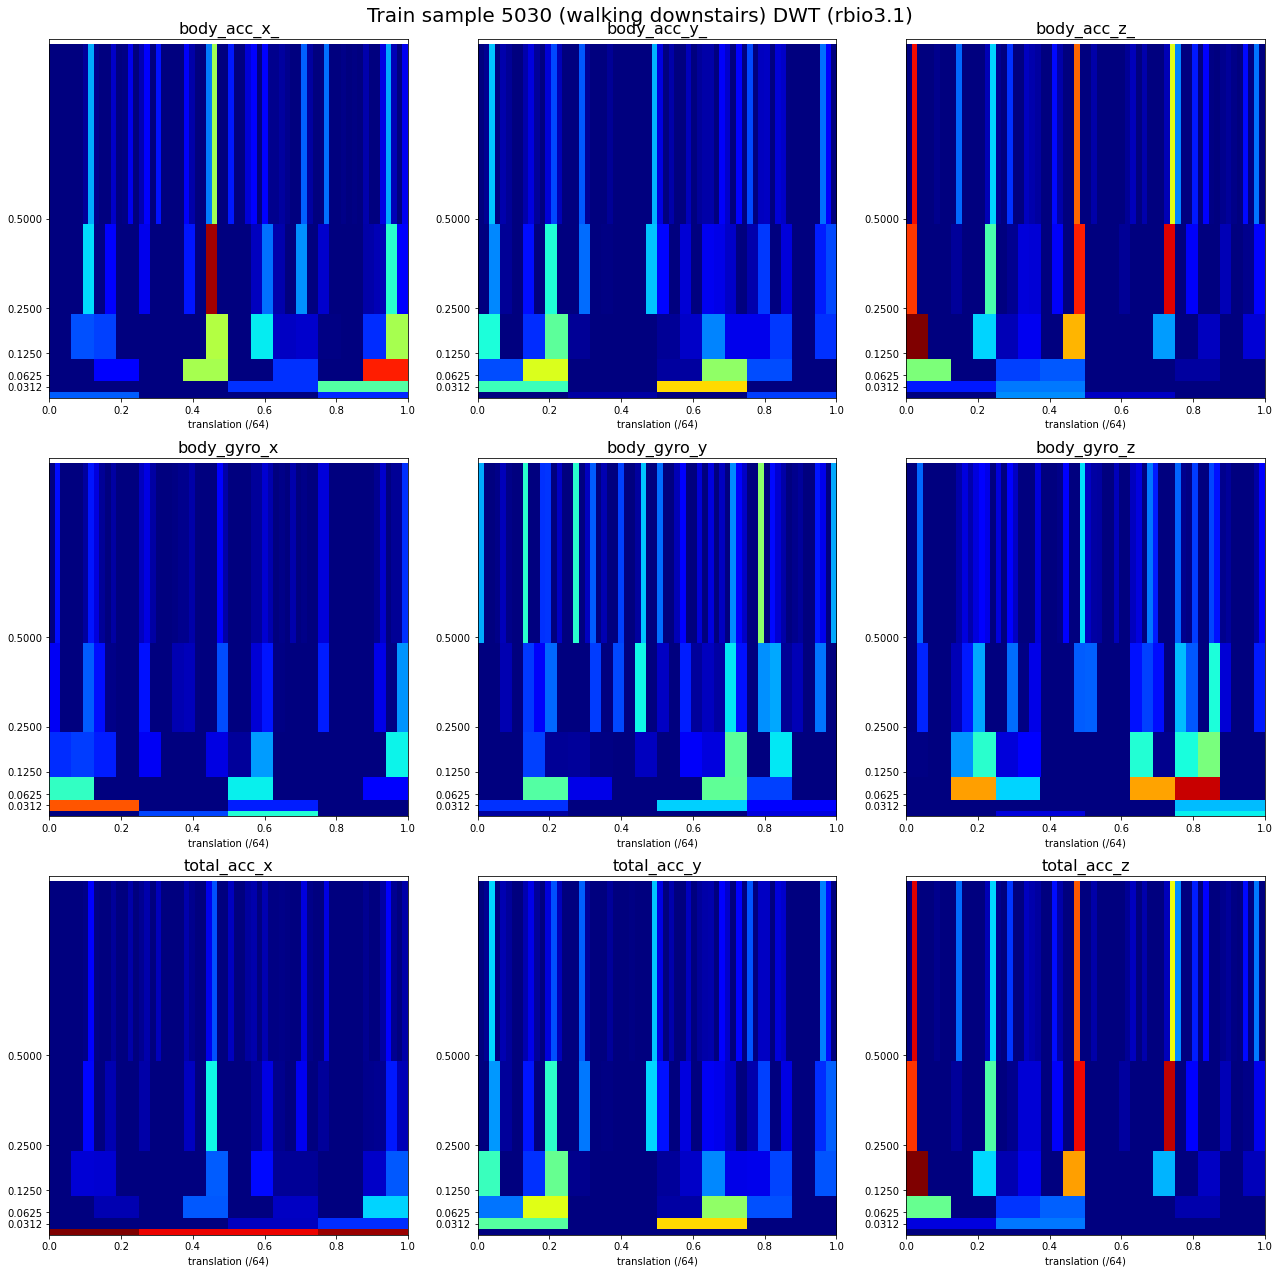

In [79]:
from numpy import log2, floor, absolute as abs
import pdb

def lepow2(x):
    return int(2 ** floor(log2(x)))

# Make a scalogram given an MRA tree
# courtesy: 
# https://stackoverflow.com/questions/16482166/basic-plotting-of-wavelet-analysis-output-in-matplotlib
def dwt_2Dplot (data, ax, cmap=plt.cm.seismic):
    bottom = 0

    vmin = min(map(lambda x: min(abs(x)), data))
    vmax = max(map(lambda x: max(abs(x)), data))

    ax.set_autoscale_on(False)

    for row in range(0, len(data)):
        scale = 2.0 ** (row - len(data))
        ax.imshow(
            list([data[row]]),
            interpolation = 'nearest',
            vmin = vmin,
            vmax = vmax,
            extent = [0, 1, bottom, bottom + scale])

        bottom += scale
    ax.set_yticks(np.power(1/2,list(range(len(data))))[1:])
    ax.set_xlabel('translation (/{})'.format(len(data[-1])))
    #print(list(range(len(data))))

# Randomly choose 10 signals from the training set
sample_set = np.random.randint(len(train_signals),size=3)
wavelets=['bior3.1','db3','coif3','sym3','rbio3.1']
#wavelets=['sym3']

for i,sig in enumerate(train_signals[sample_set]):

    for w in wavelets:

        fig_dwt, axarr_dwt = plt.subplots(figsize=(18,18), nrows=3,ncols=3)
        # components DWT coefficients
        fig_dwt.suptitle('Train sample {} ({}) DWT ({})'.format(
            sample_set[i], activities_description[train_labels[sample_set[i]]], w), fontsize=20)

        sig = sig[0:lepow2(len(signal)),:]

        for c in range(np.shape(sig)[1]):
            px,py = int(c/3), c-(3*int(c/3))
            ax = axarr_dwt[px][py]
            list_coeff = pywt.wavedec(sig[:,c], w, 'per')
            dwt_2Dplot(list_coeff, ax)
            ax.set_title(INPUT_FILES_TRAIN[c][:11], fontsize=16)
        fig_dwt.tight_layout()

plt.show()

